In [ ]:
import pandas as pd
import numpy as np
import string
from math import *
from collections import *

import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
from scipy.linalg import svd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

from matplotlib import cm

import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
cd /content/drive/MyDrive/Proyecto_Mineria_Datos

/content/drive/MyDrive/Proyecto_Mineria_Datos


In [ ]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
data.dropna(subset=['Review Text'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               22641 non-null  int64 
 1   Clothing ID              22641 non-null  int64 
 2   Age                      22641 non-null  int64 
 3   Title                    19675 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   22641 non-null  int64 
 6   Recommended IND          22641 non-null  int64 
 7   Positive Feedback Count  22641 non-null  int64 
 8   Division Name            22628 non-null  object
 9   Department Name          22628 non-null  object
 10  Class Name               22628 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.1+ MB


In [ ]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
data.drop(columns='Unnamed: 0', inplace=True)

Extraer frecuencias de palabras del texto

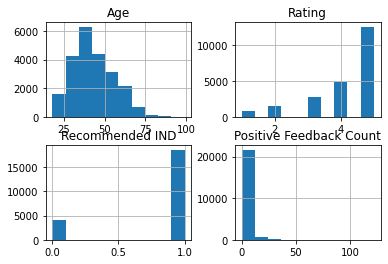

In [ ]:
data_hist = data[['Age', 'Rating', 'Recommended IND', 'Positive Feedback Count']].copy()
hist = data_hist.hist()

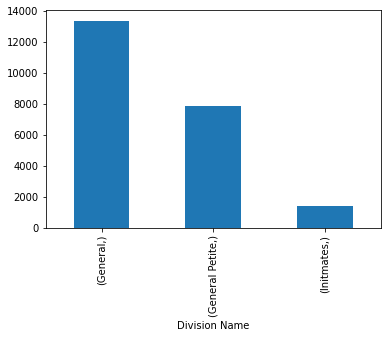

In [ ]:
data_freq = data[['Division Name']].copy()
vals = data_freq.value_counts()
vals.plot(kind='bar')

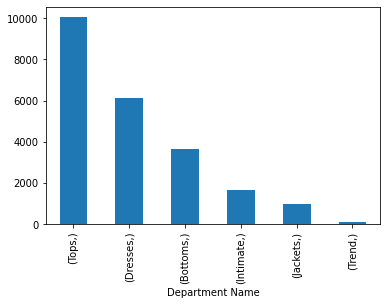

In [ ]:
data_freq = data[['Department Name']].copy()
vals = data_freq.value_counts()
vals.plot(kind='bar')

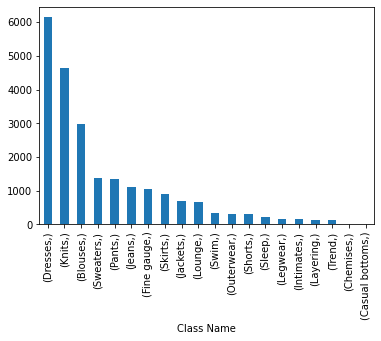

In [ ]:
data_freq = data[['Class Name']].copy()
vals = data_freq.value_counts()
vals.plot(kind='bar')

In [ ]:
#pd.get_dummies(data,columns=['Division Name', 'Department Name', 'Class Name'])

In [ ]:
data_OHE = pd.get_dummies(data, columns=['Division Name', 'Department Name', 'Class Name']).drop(columns=['Clothing ID', 'Title', 'Review Text'])

In [ ]:
data_OHE.head()

,Age,Rating,Recommended IND,Positive Feedback Count,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Blouses,Class Name_Casual bottoms,Class Name_Chemises,Class Name_Dresses,Class Name_Fine gauge,Class Name_Intimates,Class Name_Jackets,Class Name_Jeans,Class Name_Knits,Class Name_Layering,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,33,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34,5,1,4,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50,5,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,47,5,1,6,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def quitar_puntuacion(x):
    return ''.join([i for i in x if i not in string.punctuation])

In [ ]:
def quitar_stopwords(x, stopwords):
  extra_stopwords = ['im', 'also', 'would', 'like', 'really']
  return ' '.join([word for word in x.split(' ') if word not in stopwords+extra_stopwords])

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    return ' '.join([lemmatizer.lemmatize(word) for word in x.split(' ')])

In [ ]:
data['Text_minusculas'] = data['Review Text'].apply(lambda x: x.lower())

In [ ]:
data['Text_no_punct'] = data['Text_minusculas'].apply(lambda x: quitar_puntuacion(x))

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

data['Text_no_stop'] = data['Text_no_punct'].apply(lambda x: quitar_stopwords(x, stopwords))

In [ ]:
data['Text_lemmatized'] = data['Text_no_stop'].apply(lambda x: lemmatize(x))

In [ ]:
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Text_minusculas,Text_no_punct,Text_no_stop,Text_lemmatized
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky and sexy and comfo...,absolutely wonderful silky sexy comfortable,absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love this dress! it's sooo pretty. i happene...,love this dress its sooo pretty i happened t...,love dress sooo pretty happened find store g...,love dress sooo pretty happened find store g...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,i had such high hopes for this dress and reall...,i had such high hopes for this dress and reall...,high hopes dress wanted work initially ordered...,high hope dress wanted work initially ordered ...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"i love, love, love this jumpsuit. it's fun, fl...",i love love love this jumpsuit its fun flirty ...,love love love jumpsuit fun flirty fabulous ev...,love love love jumpsuit fun flirty fabulous ev...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,this shirt is very flattering to all due to th...,this shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...,shirt flattering due adjustable front tie perf...


In [ ]:
text = data['Text_lemmatized']
vectorizer = CountVectorizer(min_df = 1, lowercase=False)
X = vectorizer.fit_transform(text)
X_coo = coo_matrix(vectorizer.fit_transform(text), dtype=np.float64).tocsc()

In [ ]:
u, s, vt = svds(X_coo)

In [ ]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

SVD = u[:,:8] * s[:8]

#ax.plot(SVD[:,0], SVD[:,1], SVD[:,2], 'o')
#plt.show()

Se usará un método del codo avanzado que usa como parte de su criterio derivadas para medir el cambio experimentado. Se pretende encontrar el primer codo tal que su segunda derivada sea localmente mayor. Dicha derivada indica el grado de cambio de un punto a otro, pudiéndose usar como indicador para encontrar el codo. Y además, se usan los coeficientes silueta para medir qué tan parecidos entre sí son los elementos de un clúster, factor que se quiere maximizar también.

Para maximizar ambos, se ordenan ascendentemente los coeficientes silueta primero y en base a ellos se ordenan las segundas derivadas para encontrar aquella tal que funja de máximo local

In [ ]:
def continue_finding_elbow(SSE_d2x, i, tol):
    # Condicion 1:
    if( abs(SSE_d2x[i]) >= abs(SSE_d2x[i-1]) ):
        return True
    # Condicion 2:
    elif( abs(SSE_d2x[i]-SSE_d2x[i-1]) < tol ):
        return True
    return False

In [ ]:
def plot_clusters(X,labels,colors):        
    for i in range( len(labels) ):
        plt.plot( X[i][0], X[i][1], 'ro', color=colors[labels[i]] )

In [ ]:
def plot_silhouette(X,clustering):
    labels = np.unique( clustering.fit_predict(X) )
    num_clusters = labels.shape[0]
    
    silhouette_vals = silhouette_samples(X, clustering.fit_predict(X), metric='euclidean')

    y_ax_lower, y_ax_upper = 0,0
    yticks = []
    for i,c in enumerate(labels):
        c_silhouette_vals = silhouette_vals[ clustering.fit_predict(X) == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / num_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                 c_silhouette_vals,
                 height=1.0,
                 edgecolor='none',
                 color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    return silhouette_avg

In [ ]:
def how_many_clusters(X, max_clusters,colors):
    num_clusters = 0
    SSE          = []
    SSE_d2x      = [] #Esta lista empieza con n_clusters=1
    silhouettes  = []
    
        
    while( num_clusters < max_clusters+1): #Para calcular la derivada del siguiente
        num_clusters += 1
        
        clustering = KMeans(n_clusters=num_clusters, init="k-means++", n_init=10, max_iter=300, random_state=42).fit(X)
        
        if num_clusters < max_clusters+1:
            plt.subplot(max_clusters,2,2*num_clusters-1)
            plot_clusters(X,clustering.labels_,colors)
        
            if( num_clusters > 1 ):
                plt.subplot(max_clusters,2,2*num_clusters)
                silhouettes.append(plot_silhouette(X,clustering))
        
        SSE.append( clustering.inertia_ )
        
        #Calculamos la segunda derivada del punto anterior normalizando ademas para que no influyan las proporciones
        if( num_clusters > 2 ):
            SSE_d2x.append( (SSE[-3]+SSE[-1]-2*SSE[-2]) / (SSE[-3]-SSE[-1]) )
    
    index_silhouettes = np.argsort(-np.array(silhouettes))

    best_d2x=[SSE_d2x[i] for i in index_silhouettes]
    best_d2x.insert(0,0)

    i=1
    while continue_finding_elbow(best_d2x, i, 0.2):
        i+=1
    
    elbow = index_silhouettes[i-1]+1        
        
    return SSE,SSE_d2x, elbow

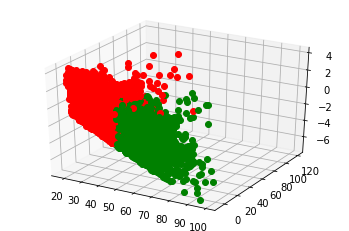

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

kmeans = KMeans(n_clusters=2)

kmeans.fit(SVD)
colors = ['r', 'g', 'b']
for i, punto in enumerate(SVD):
    ax.plot([punto[0]], [punto[1]], [punto[2]], 'o', color=colors[kmeans.labels_[i]])

plt.show()

En general no se observa mucha distincion entre los clusters usando unicamente informacion de las reseñas. Pareciera ser un cluster unico, y el metodo solo encontro dos clusters que realmente parecen estar muy conectados entre si.

In [ ]:
new_X = np.concatenate([SVD, data_OHE.values], axis=1)

In [ ]:
u, s, vt = svd(new_X)

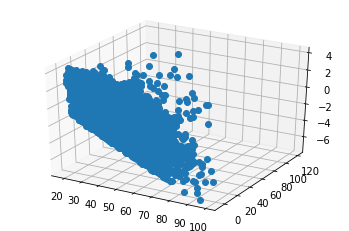

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

SVD = u[:,:3] * s[:3]

ax.plot(SVD[:,0], SVD[:,1], SVD[:,2], 'o')
plt.show()

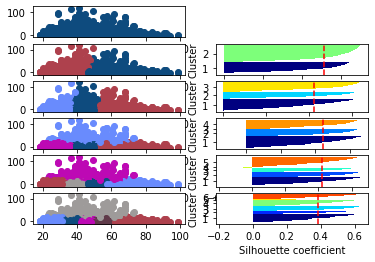

In [ ]:
colors = [[np.random.random(), np.random.random(), np.random.random()] for i in range(6)]
SSE, SSE_d2x, codo = how_many_clusters(SVD, 6, colors)

In [ ]:
print("Codo optimo encontrado por el algoritmo:", codo)

Codo optimo encontrado por el algoritmo: 3


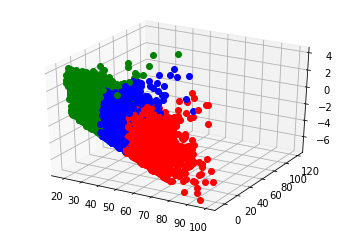

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

kmeans = KMeans(n_clusters=3)

kmeans.fit(SVD)
colors = ['r', 'g', 'b', 'y']
for i, punto in enumerate(SVD):
    ax.plot([punto[0]], [punto[1]], [punto[2]], 'o', color=colors[kmeans.labels_[i]])

plt.show()

Ahora vamos a analizar qué palabras suelen acompañarse entre sí

Lift mayor a 1 para que sea significativa la regla sin que influyan mucho las frecuencias de los elementos

In [ ]:
def obtain_rules(data, min_support, max_len=None):
    transactions = []
    for i, row in data.iterrows():
        transactions.append(row.Text_lemmatized.split(' '))
    te = TransactionEncoder()

    ohe_array = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(ohe_array, columns=te.columns_)

    frequent_sets = apriori(df, min_support=min_support, max_len=max_len, use_colnames=True)
    interesting_rules = association_rules(frequent_sets, metric = 'lift', min_threshold = 1)
    #interesting_rules.sort_values(by='lift', ascending=False)
    frequent_sets['size'] = frequent_sets['itemsets'].apply(lambda x: len(x))
    interesting_rules['ant_size'] = interesting_rules['antecedents'].apply(lambda x: len(x))
    interesting_rules['con_size'] = interesting_rules['consequents'].apply(lambda x: len(x))

    return frequent_sets, interesting_rules

In [ ]:
rules_df = []
sets_df = []
for i in range(1,6):
    frequent_sets, interesting_rules = obtain_rules(data.loc[data['Rating'] == i].copy(), min_support=0.02)
    rules_df.append(interesting_rules)
    sets_df.append(frequent_sets)

Tras experimentación, parece ser que aquellas reglas de asociación que involucran a más de 2 palabras no suelen ser muy informativas o distinguibles para los conjuntos de calificaciones. Se intentará entonces visualizar aquellas palabras frecuentes por calificacion y su dinamica a lo largo de dichas calificaciones por medio de graficas de barras. Adicionalmente, se implementará un mapa de calor para visualizar las distribuciones de palabras para cada calificacion.

In [ ]:
rules_df[4].loc[(rules_df[4]['ant_size'] > 1) | (rules_df[4]['con_size'] > 1)].sort_values(by='support', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ant_size,con_size
1825,(size),"(love, fit)",0.302392,0.159809,0.062679,0.207278,1.297042,0.014355,1.059882,1,2
1822,"(love, fit)",(size),0.159809,0.302392,0.062679,0.392216,1.297042,0.014355,1.147788,2,1
1824,(fit),"(love, size)",0.395056,0.116746,0.062679,0.158660,1.359011,0.016558,1.049817,1,2
1823,"(love, size)",(fit),0.116746,0.395056,0.062679,0.536885,1.359011,0.016558,1.306251,2,1
1396,"(love, fit)",(color),0.159809,0.280702,0.052472,0.328343,1.169723,0.007614,1.070931,2,1
1397,"(love, color)",(fit),0.123844,0.395056,0.052472,0.423696,1.072497,0.003547,1.049696,2,1
1398,"(fit, color)",(love),0.115391,0.402552,0.052472,0.454734,1.129628,0.006021,1.095700,2,1
1399,(love),"(fit, color)",0.402552,0.115391,0.052472,0.130349,1.129628,0.006021,1.017200,1,2
1400,(fit),"(love, color)",0.395056,0.123844,0.052472,0.132822,1.072497,0.003547,1.010353,1,2
1401,(color),"(love, fit)",0.280702,0.159809,0.052472,0.186932,1.169723,0.007614,1.033359,1,2


In [ ]:
rules_df = []
sets_df = []
for i in range(1,6):
    frequent_sets, interesting_rules = obtain_rules(data.loc[data['Rating'] == i].copy(), min_support=0.03, max_len=2)
    rules_df.append(interesting_rules)
    sets_df.append(frequent_sets)

In [ ]:
rules_df[0].sort_values(by='support', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ant_size,con_size
181,(look),(fit),0.294762,0.264312,0.092570,0.314050,1.188178,0.014661,1.072509,1,1
180,(fit),(look),0.264312,0.294762,0.092570,0.350230,1.188178,0.014661,1.085366,1,1
202,(fit),(size),0.264312,0.192448,0.088916,0.336406,1.748031,0.038050,1.216936,1,1
203,(size),(fit),0.192448,0.264312,0.088916,0.462025,1.748031,0.038050,1.367515,1,1
122,(dress),(look),0.259440,0.294762,0.082826,0.319249,1.083071,0.006353,1.035970,1,1
123,(look),(dress),0.294762,0.259440,0.082826,0.280992,1.083071,0.006353,1.029975,1,1
192,(fit),(ordered),0.264312,0.186358,0.079172,0.299539,1.607331,0.029915,1.161581,1,1
193,(ordered),(fit),0.186358,0.264312,0.079172,0.424837,1.607331,0.029915,1.279094,1,1
302,(size),(ordered),0.192448,0.186358,0.075518,0.392405,2.105651,0.039653,1.339119,1,1
258,(top),(look),0.226553,0.294762,0.075518,0.333333,1.130854,0.008738,1.057856,1,1


In [ ]:
sets_df[0].sort_values(by='support', ascending=False).head(30)

,support,itemsets,size
73,0.294762,(look),1
52,0.264312,(fit),1
41,0.259440,(dress),1
48,0.239951,(fabric),1
155,0.226553,(top),1
10,0.205847,(back),1
0,0.198538,(),1
133,0.192448,(size),1
92,0.186358,(ordered),1
82,0.175396,(material),1


In [ ]:
'love' in frozenset({'love'})

True

In [ ]:
def plot_word_freq(sets_df, word):
    supports = []
    for set_df in sets_df:
        found=False
        for i in range(set_df.values.shape[0]):
            if word in set_df.values[i][1] and set_df.values[i][2] == 1:
                support = set_df.values[i][0]
                supports.append(support)
                found=True
        if found == False:
            supports.append(0)

    supports_df = pd.DataFrame({'support' : supports})
    #print(supports_df)
    supports_df.plot(kind='bar')
    plt.show()

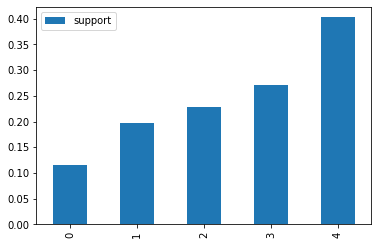

In [ ]:
plot_word_freq(sets_df, 'love')

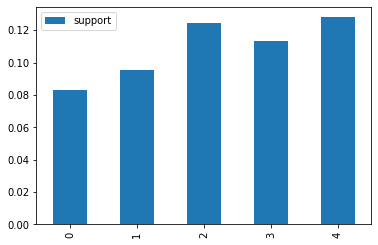

In [ ]:
plot_word_freq(sets_df, 'beautiful')

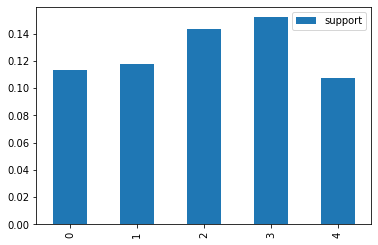

In [ ]:
plot_word_freq(sets_df, 'cute')

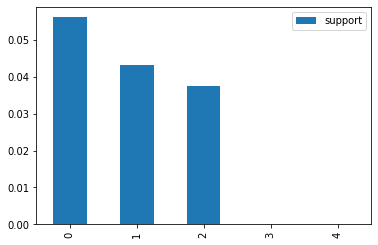

In [ ]:
plot_word_freq(sets_df, 'bad')

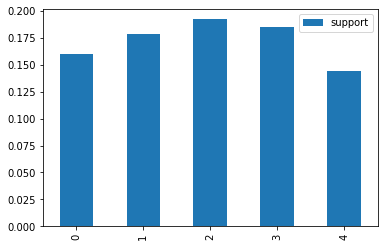

In [ ]:
plot_word_freq(sets_df, 'small')

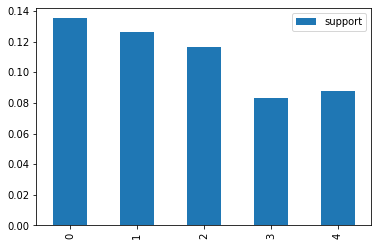

In [ ]:
plot_word_freq(sets_df, 'quality')

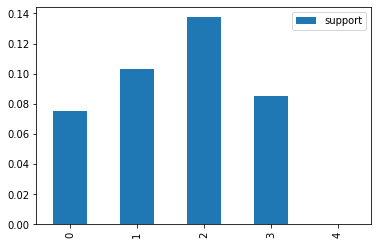

In [ ]:
plot_word_freq(sets_df, 'however')

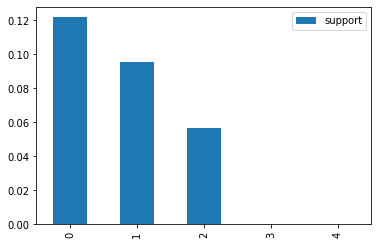

In [ ]:
plot_word_freq(sets_df, 'disappointed')

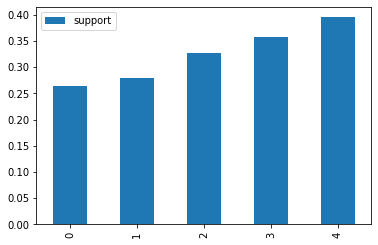

In [ ]:
plot_word_freq(sets_df, 'fit')

In [ ]:
set_df = sets_df[0].copy()
set_df['word'] = set_df['itemsets'].apply(lambda x: list(x)[0])
set_df.set_index('word', inplace=True)
set_df.info()
#set_df.head(20)
#set_df.loc['love']['support']

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries,  to wear
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   374 non-null    float64
 1   itemsets  374 non-null    object 
 2   size      374 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 11.7+ KB


In [ ]:
import seaborn as sns

def rule_heatmap(rules_df, sets_df, rating):
    df = rules_df[rating-1].copy()
    set_df = sets_df[rating-1].copy()
    set_df['word'] = set_df['itemsets'].apply(lambda x: list(x)[0])
    set_df.set_index('word', inplace=True)
    df['antecedents_aux'] = df['antecedents'].apply(lambda x: list(x)[0])
    df['consequents_aux'] = df['consequents'].apply(lambda x: list(x)[0])
    unique_vals = pd.unique(df['antecedents_aux']) 
    for i in range(len(unique_vals)):
        for j in range(len(unique_vals)):
            i_val = unique_vals[i]
            j_val = unique_vals[j]
            # Por alguna razon esta parte del codigo provoca algun error, por lo cual la diagonal del mapa de calor se mostrara negra
            #if i_val == j_val:
            #    row = {}
            #    for column in df.columns:
            #        if column == 'antecedents_aux':
            #            row[column] = [i_val]
            #        elif column == 'consequents_aux':
            #            row[column] = [j_val]
            #        elif column == 'support':
            #            row[column] = [np.float64(set_df.loc[i_val]['support'])]
                        #if len(row[column]) > 1:
                        #    print('hola')
            #        else:
            #            row[column] = [np.NaN]
            #    df = pd.concat([df, pd.DataFrame(row)], axis=0)
            if df.loc[(df['antecedents_aux'] == i_val) & (df['consequents_aux'] == j_val)].shape[0] == 0:
                row = {}
                for column in df.columns:
                    if column == 'antecedents_aux':
                        row[column] = [i_val]
                    elif column == 'consequents_aux':
                        row[column] = [j_val]
                    elif column == 'support':
                        row[column] = [np.float64(0.0)]
                    else:
                        row[column] = [np.NaN]
                df = pd.concat([df, pd.DataFrame(row)], axis=0)
    #df.reset_index(inplace=True)
    #print(df[['support', 'antecedents_aux', 'consequents_aux']])
    figure, ax = plt.subplots(figsize=(17, 20))
    ax = sns.heatmap(df.pivot("antecedents_aux", "consequents_aux", "support"))
    plt.show()

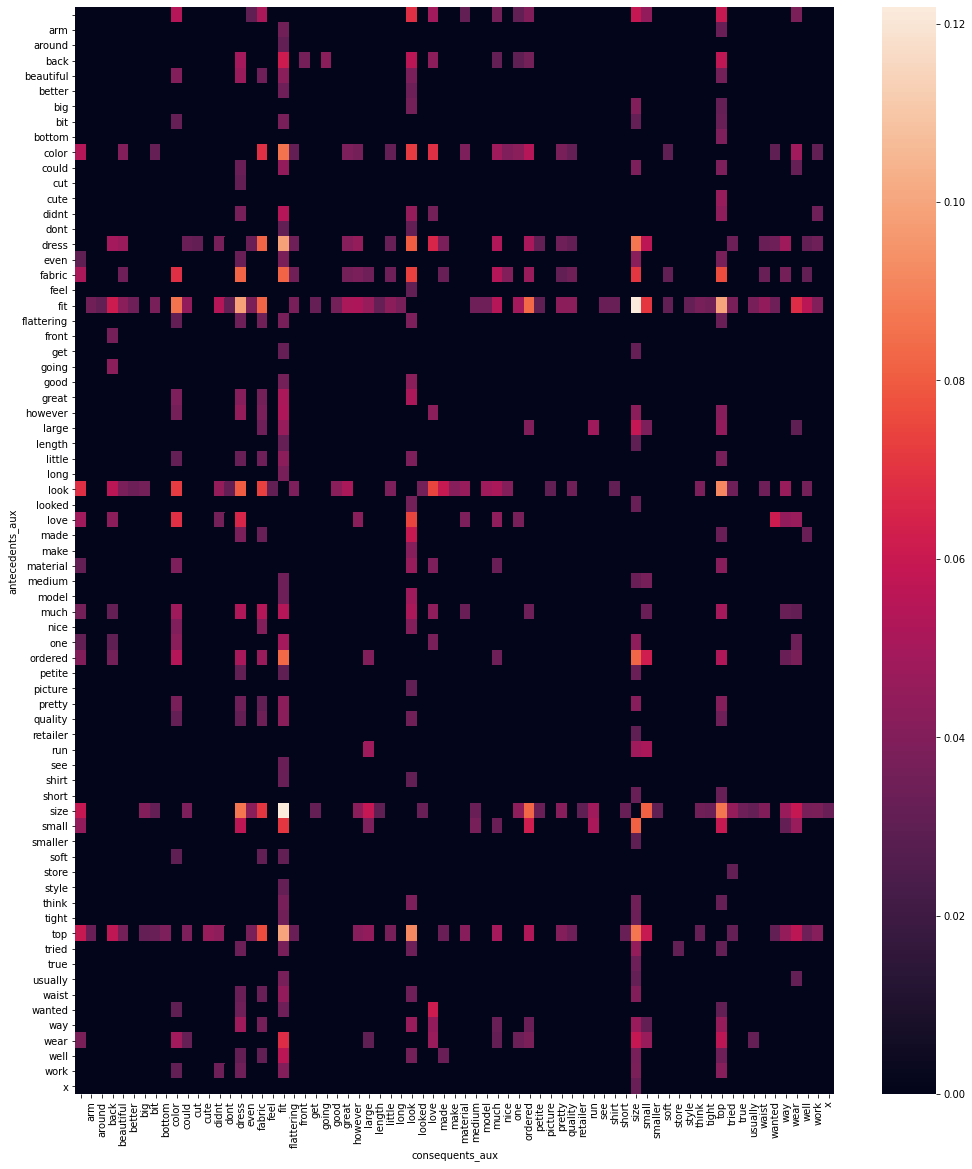

In [ ]:
rule_heatmap(rules_df, sets_df, 3)